# MULTI-CLASS TEXT CLASSIFICATION:

##### Goal:

 We are going to segregate the customer complaints by pre-defined categories.

##### Importing libraries:

In [1]:
import os
print(os.listdir("C:\\Users\\aruns\\Downloads\\My Proj\\NLP\\Consumer Complaints(Text Analysis)"))

['.ipynb_checkpoints', 'rows.csv', 'Untitled.ipynb']


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

##### Loading the dataset:

In [3]:
df = pd.read_csv('rows.csv')
df.shape

C:\Users\aruns\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (4,5,6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1282355, 18)

##### Exploratory Data analysis:

In [4]:
df.head(1).T#to check all in a single row by transposing.

,0
Date received,05/10/2019
Product,Checking or savings account
Sub-product,Checking account
Issue,Managing an account
Sub-issue,Problem using a debit or ATM card
Consumer complaint narrative,NaN
Company public response,NaN
Company,NAVY FEDERAL CREDIT UNION
State,FL
ZIP code,328XX


# OBSERVATIONS: 01

For text analysis we only two columns from the above dataset since we are going to classify the customer complaints by products it falls into.

In [5]:
#Let's create a new dataframe with only the above two columns:

df1 = df[['Product','Consumer complaint narrative']].copy()

In [6]:
df1.head()

,Product,Consumer complaint narrative
0,Checking or savings account,NaN
1,Checking or savings account,NaN
2,Debt collection,NaN
3,"Credit reporting, credit repair services, or o...",NaN
4,Checking or savings account,NaN


In [7]:
df1.shape

(1282355, 2)

In [8]:
df1.Product.unique()#to check the unique value in the "Product" column.

array(['Checking or savings account', 'Debt collection',
       'Credit reporting, credit repair services, or other personal consumer reports',
       'Mortgage', 'Student loan', 'Vehicle loan or lease',
       'Credit card or prepaid card',
       'Payday loan, title loan, or personal loan',
       'Money transfer, virtual currency, or money service',
       'Credit reporting', 'Credit card', 'Bank account or service',
       'Consumer Loan', 'Prepaid card', 'Other financial service',
       'Payday loan', 'Money transfers', 'Virtual currency'], dtype=object)

In [9]:
len(df1.Product.unique())#totally we've 18 products.

18

# OBSERVATIONS: 02

In total 1282355 rows(complaints) has only falls under 18 products.

##### Let's check the missing values:

In [10]:
df1.isnull().sum()

Product                              0
Consumer complaint narrative    898791
dtype: int64

In [11]:
missing_df = df1.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(df1.shape[0]-missing_df['missing values'])/df1.shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)

,variable,missing values,filling factor (%)
0,Consumer complaint narrative,898791,29.910906
1,Product,0,100.000000


# OBSERVATIONS: 03

 1. In total 1282355 "Consumer complaint narrative" we have 898791 row has null values.
 2. We have only 30% of text and remaining 70% of missing values in  "Consumer complaint narrative".

In [12]:
# Remove missing values (NaN)
df2 = df1[pd.notnull(df1['Consumer complaint narrative'])]

In [13]:
df2.shape#Observations are reduce from 1282355 to 383564 rows.

(383564, 2)

In [14]:
df2.columns = ['Product','Complaints']#renamed from 'Consumer complaint narrative' to 'Consumer complaint'

In [15]:
#Let's explore the first column "Product":

pd.DataFrame(df2.Product.unique()).values

array([['Credit reporting, credit repair services, or other personal consumer reports'],
       ['Debt collection'],
       ['Student loan'],
       ['Mortgage'],
       ['Credit card or prepaid card'],
       ['Checking or savings account'],
       ['Money transfer, virtual currency, or money service'],
       ['Vehicle loan or lease'],
       ['Payday loan, title loan, or personal loan'],
       ['Credit card'],
       ['Bank account or service'],
       ['Credit reporting'],
       ['Consumer Loan'],
       ['Prepaid card'],
       ['Payday loan'],
       ['Money transfers'],
       ['Other financial service'],
       ['Virtual currency']], dtype=object)

# OBSERVATIONS: 04

  As we can see that in our 18 products are not really unique. For example, "Credit card" and "Prepaid card" also falls under "Credit card or prepaid card" so lets check one by one. 

In [16]:
# For the computation is time consuming, the data was sampled
df3 = df2.sample(10000, random_state=1).copy()#we took 1000 samples from 3,83,564 rows.

In [17]:
df3.shape

(10000, 2)

In [18]:
#Let's remove the duplicate or multi-lablled products:

df3.replace({'Product': 
             {'Credit reporting, credit repair services, or other personal consumer reports': 
              'Credit reporting, repair, or other',
              'Credit reporting': 'Credit reporting, repair, or other',
              'Credit card':'Credit card or prepaid card',
              'Prepaid card':'Credit card or prepaid card',
              'Payday loan':'Payday loan, title loan, or personal loan',
              'Money transfers':'Money transfer, virtual currency, or money service',
              'Virtual currency':'Money transfer, virtual currency, or money service'}},
            inplace= True)

In [19]:
pd.DataFrame(df3.Product.unique())#Now reduce the classes from 18 to 12 products.

,0
0,"Credit reporting, repair, or other"
1,Debt collection
2,Consumer Loan
3,Credit card or prepaid card
4,Mortgage
5,Vehicle loan or lease
6,Student loan
7,"Payday loan, title loan, or personal loan"
8,Checking or savings account
9,Bank account or service


# VISUALIZATIONS:

Text(0, 0.5, 'Number of Complaints')

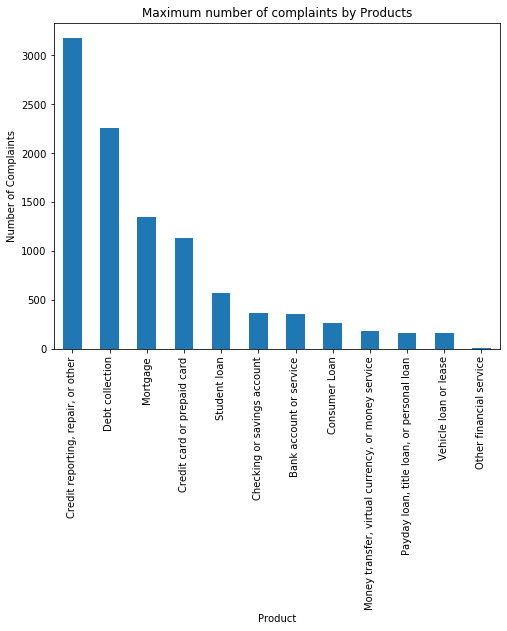

In [27]:
fig = plt.figure(figsize=(8,6))
df3.groupby('Product').Complaints.count().sort_values(ascending=False).plot.bar()
plt.title('Maximum number of complaints by Products')
plt.ylabel('Number of Complaints')

# OBSERVATIONS: 05

  As per the above plot we can see that the maximum complaints are from "Credit reporting, repair, or other" and the minimum complaints are from "Other financial service".

# TF-IDF:

##### TF-IDF = "Term Frequency – Inverse Document Frequency". 
  
Term Frequency is summarizes how often a given word appears within a document.
  
  ### TF-IDF=TF/IDF
  
  ##### TF = Number of times the term appears in the doc / Total number of words in the doc
            
  
  Inverse Document Frequency: This downscales words that appear a lot across documents. A term has a high IDF score if it appears in a few documents. Conversely, if the term is very common among documents (i.e., “the”, “a”, “is”), the term would have a low IDF score.
  
  ##### IDF = ln(Number of docs / Number docs the term appears in)
                 
                 
##### TfidfVectorizer class can be initialized with the following parameters:

min_df: remove the words from the vocabulary which have occurred in less than ‘min_df’ number of files.

max_df: remove the words from the vocabulary which have occurred in more than _‘maxdf’ * total number of files in corpus.

sublinear_tf: set to True to scale the term frequency in logarithmic scale.

stop_words: remove the predefined stop words in 'english'.

use_idf: weight factor must use inverse document frequency.

ngram_range: (1, 2) to indicate that unigrams and bigrams will be considered.

# Splitting the Dataset:

In [28]:
X = df3['Complaints'] # Our text columns to analyse
y = df3['Product'] # Target column we want to predict (i.e., the 12 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

In [29]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

from sklearn.svm import LinearSVC
model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

In [30]:
new_complaint = """I have been enrolled back at XXXX XXXX University in the XX/XX/XXXX. Recently, i have been harassed by \
Navient for the last month. I have faxed in paperwork providing them with everything they needed. And yet I am still getting \
phone calls for payments. Furthermore, Navient is now reporting to the credit bureaus that I am late. At this point, \
Navient needs to get their act together to avoid me taking further action. I have been enrolled the entire time and my \
deferment should be valid with my planned graduation date being the XX/XX/XXXX."""

print(model.predict(fitted_vectorizer.transform([new_complaint])))

['Student loan']


In [33]:
df3[df3['Complaints'] == new_complaint]

,Product,Complaints
877489,Student loan,I have been enrolled back at XXXX XXXX Univers...


In [34]:
new_complaint1 = """I need apply a new credit card so kindly kind me the details."""

print(model.predict(fitted_vectorizer.transform([new_complaint1])))

['Credit card or prepaid card']


In [43]:
new_complaint2 = """I lost my card."""

print(model.predict(fitted_vectorizer.transform([new_complaint2])))

['Credit card or prepaid card']
